# Training of Fully Convolutional Network

The aim of this notebook is to train..................

### $\bullet$ Importing libraries and utilitary functions

In [1]:
# Import python libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import utilitary functions and module defining the Unet model.
#from utils import get_dataset_from_folders
#from train_data_augmentation import make_train_generator
from scripts.model import fully_convolutional_network
from scripts.plots import plot_history

In [2]:
# Set seeds of random number generators to guarantee reproducibility.
#np.random.seed(1)
#tensorflow.random.set_seed(2)

### $\bullet$ Setting different paths

In [3]:
# Variable defining where to save the dataset locally, relative to "~/.keras/datasets"
mnist_path = "mnist.npz"

# Variable defining where models will be stored.
model_save_path = "./Models/Fully Connected Network/"

### $\bullet$ Load images from the dataset

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data(path = mnist_path)

# Add channel dimention and convert to float32.
train_images = np.expand_dims(train_images, axis = -1).astype(np.float32) / 255.
test_images  = np.expand_dims(test_images , axis = -1).astype(np.float32) / 255.

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels  = tf.keras.utils.to_categorical(test_labels)

print(f'Training set contains {len(train_images)} images.')
print(f'Test set contains {len(test_images)} images.')

Training set contains 60000 images.
Test set contains 10000 images.


### $\bullet$ Training Fully Convolutional Model using Data Augmentation

In [5]:
def crossentropy(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, tf.squeeze(y_pred))
    

def accuracy(y_true, y_pred):
    return tf.keras.metrics.categorical_accuracy(y_true, tf.squeeze(y_pred))
    

# Setting up parameters used for training
number_epochs = 10
batch_size = 50
early_stopping = EarlyStopping(patience = 50, verbose = 1)
model_checkpoint = ModelCheckpoint(filepath = model_save_path, save_weights_only = False, monitor = 'val_accuracy', save_best_only = True)

# Building model.
model = fully_convolutional_network(show_summary = True)

# Compiling model.
model.compile(optimizer = 'adam', loss = crossentropy, metrics = [accuracy])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 32)    320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 128)   401536    
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, None, None, 128)   0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 10)    1

In [6]:
# Training
history = model.fit(train_images, train_labels, validation_split = 0.3, batch_size = batch_size, epochs = number_epochs, callbacks = [early_stopping, model_checkpoint])

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
41700/42000 [============================>.] - ETA: 0s - loss: 0.2565 - accuracy: 0.9215WARNING:tensorflow:From C:\Anaconda3\envs\image_proc\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Models/Fully Connected Network/assets
42000/42000 [==============================] - 10s 228us/sample - loss: 0.2552 - accuracy: 0.9219 - val_loss: 0.0614 - val_accuracy: 0.9819
Epoch 2/10
42000/42000 [==============================] - 8s 184us/sample - loss: 0.0908 - accuracy: 0.9732 - val_loss: 0.0544 - val_accuracy: 0.9830
Epoch 3/10
42000/42000 [==============================] - 8s 191us/sample - loss: 0.0661 - accuracy: 0.9797 - val_los

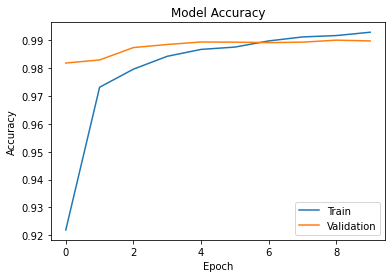

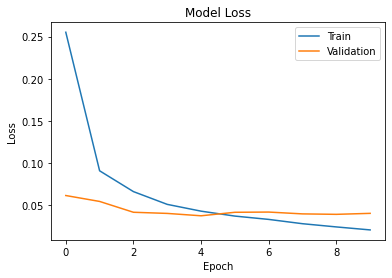

In [7]:
plot_history(history)

In [8]:
# Load best model saved by ModelCheckpoint
model = tf.keras.models.load_model(model_save_path, compile = False)
model.compile(optimizer = 'adam', loss = crossentropy, metrics = [accuracy])

# Evaluate best model
model.evaluate(test_images, test_labels);

10000/10000 [==============================] - 1s 122us/sample - loss: 0.0322 - accuracy: 0.9909
